In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.mane_utils import *
from scripts.plotting import *

In [2]:
config_file = '../snakemake/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = '../'+expand(config['data']['ab'], species='human')[0]
filt_ab = '../'+expand(config['data']['filt_ab'], species='human')[0]
read_annot = '../'+expand(config['data']['read_annot'], species='human')[0]
ref_t_metadata = '../'+expand(config['ref']['t_info'], species='human')[0]
ref_g_metadata = '../'+expand(config['ref']['g_info'], species='human')[0]
t_metadata = '../'+expand(config['ref']['cerberus']['t_info'], species='human')[0]
lib_meta = '../'+expand(config['data']['meta'], species='human')[0]
swan_file = '../'+expand(config['data']['sg'], species='human')[0]
cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='human')[0]
cerb_t_metadata = '../'+expand(config['data']['t_info'], species='human')[0]
major_isos = '../'+expand(config['data']['major_isos'], species='human', obs_col='sample')[0]
orf_fa = '../'+expand(config['data']['p_pred']['orf_fa'], species='human')[0]
pp_bed = '../'+expand(config['data']['p_pred']['cds_bed'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_lib_meta = '../'+expand(config['data']['meta'], species='mouse')[0]

# Figures 4 and S11

## MANE analyses using libraries

Read in graph from ../data/human/swan_graph.p
triplet
# genes: 16709
68.14% (11385/16709) of genes have a non-MANE predominant triplet in 80% of expressed datasets
13.91% of genes (2324/16709) have predom == mane in all datasets
25.79% of genes (4310/16709) have predom != mane in all datasets
29.38% (262064/891854) ranked gene / library combinations where predominant isoform is not MANE
66.87% (421170/629790) of gene / dataset combos where MANE is predominant triplet also have a secondary expressed triplet
33.93% (237809/700821) of gene / dataset combos  where predominant triplet is not MANE have MANE expression
66.07% (463012/700821) of gene / dataset combos  where predominant triplet is not MANE have NO MANE expression
86.09% (14385/16709) of genes have >= 1 dataset where the predominant triplet is not MANE
74.21% (12399/16709) of genes have >= 1 dataset where the predominant triplet is MANE

tss
# genes: 16712
30.72% (5134/16712) of genes have a non-MANE predominant tss in 80% of ex

/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/mane_utils.py:327: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize)


13.04% (150408/1153319) ranked gene / library combinations where predominant IC is not MANE
62.90% (630870/1002911) of gene / dataset combos where MANE is predominant ic also have a secondary expressed ic
40.09% (131802/328735) of gene / dataset combos  where predominant ic is not MANE have MANE expression
59.91% (196933/328735) of gene / dataset combos  where predominant ic is not MANE have NO MANE expression
70.64% (11803/16709) of genes have >= 1 dataset where the predominant ic is not MANE
90.59% (15137/16709) of genes have >= 1 dataset where the predominant ic is MANE

tes
# genes: 16710
45.15% (7544/16710) of genes have a non-MANE predominant tes in 80% of expressed datasets
36.03% of genes (6021/16710) have predom == mane in all datasets
11.25% of genes (1880/16710) have predom != mane in all datasets
22.92% (256062/1117301) ranked gene / library combinations where predominant TES is not MANE
30.35% (261406/861239) of gene / dataset combos where MANE is predominant tes also have

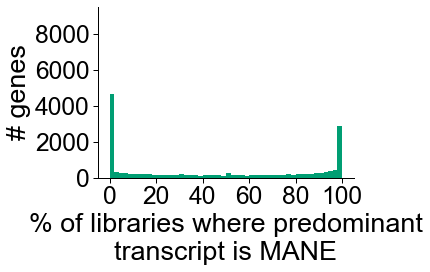

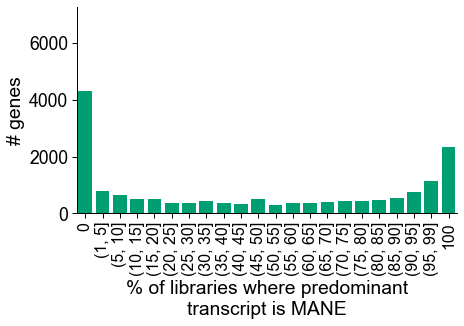

<Figure size 288x324 with 0 Axes>

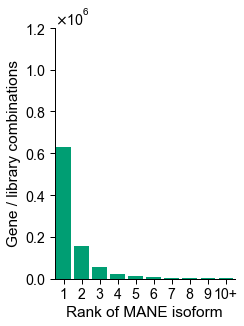

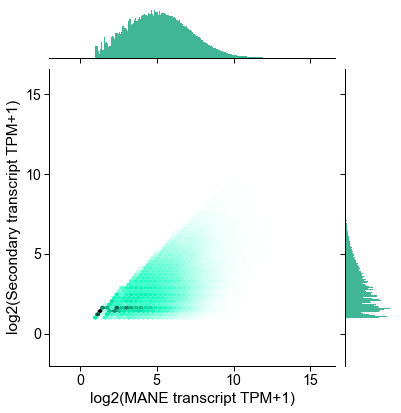

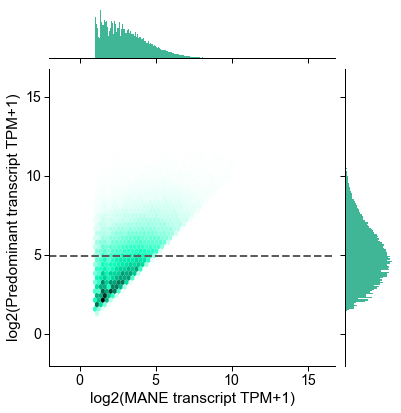

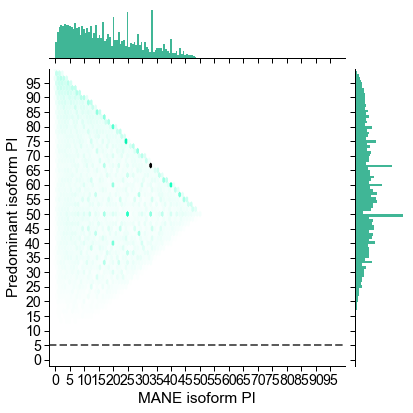

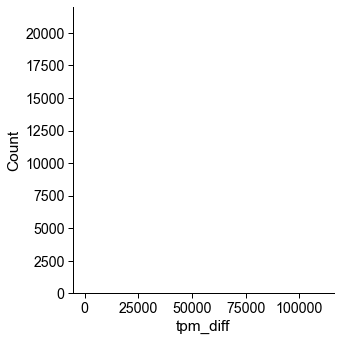

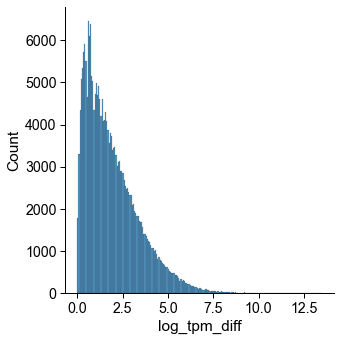

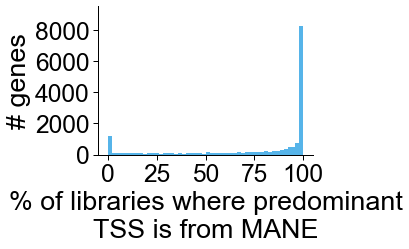

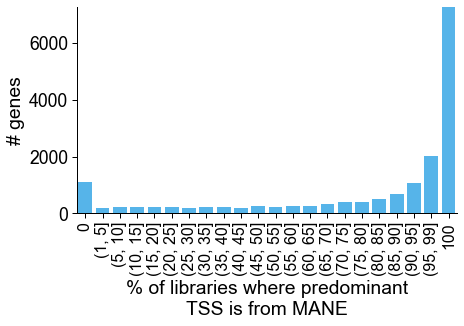

<Figure size 288x324 with 0 Axes>

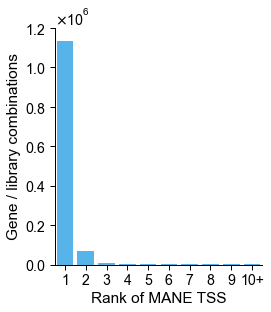

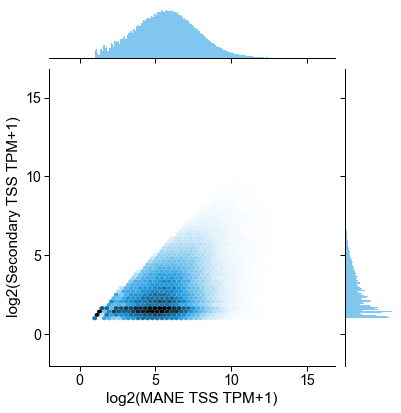

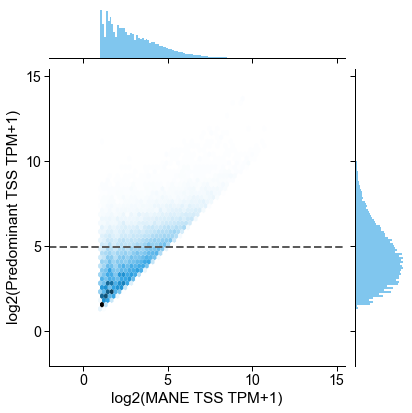

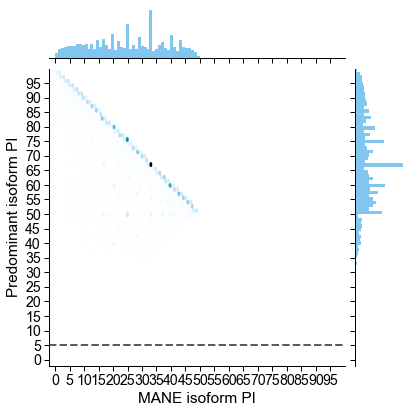

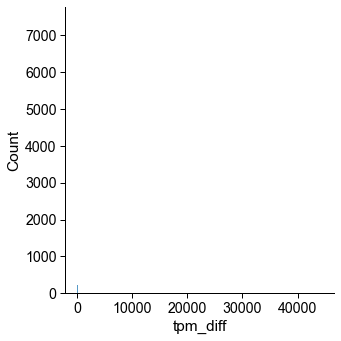

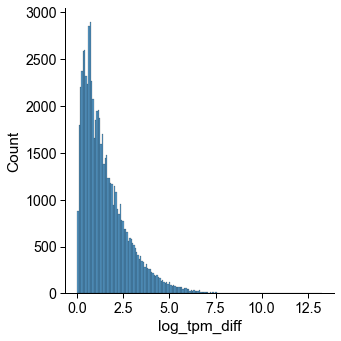

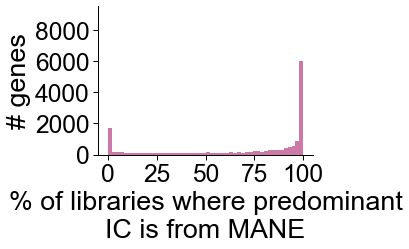

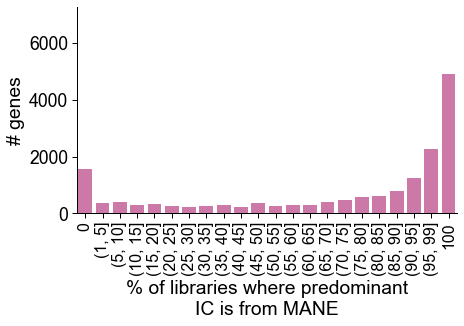

<Figure size 288x324 with 0 Axes>

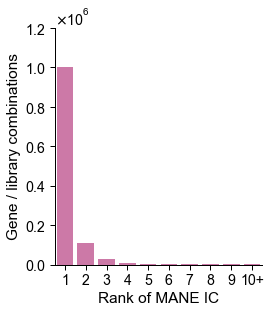

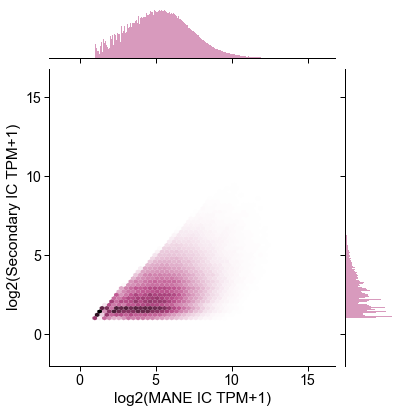

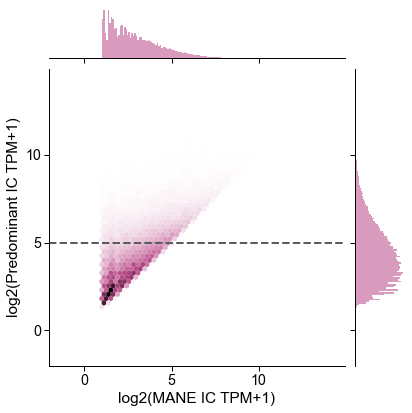

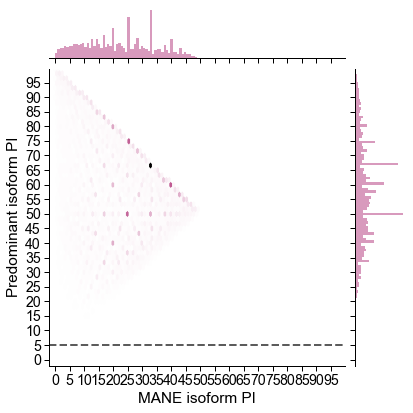

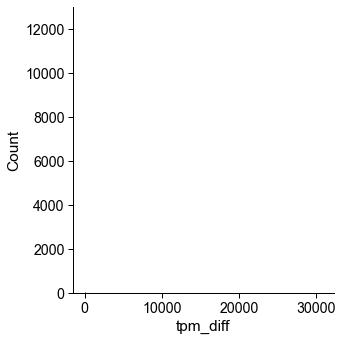

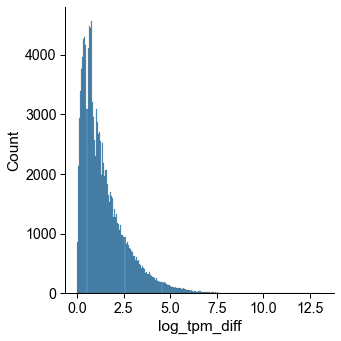

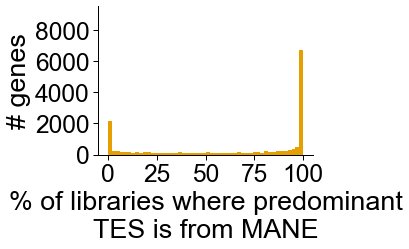

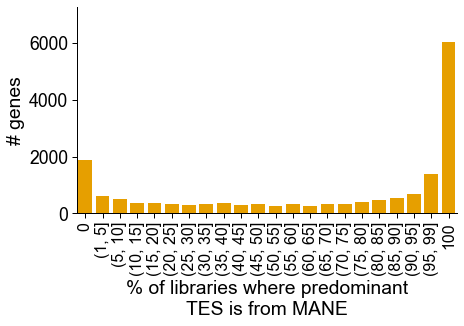

<Figure size 288x324 with 0 Axes>

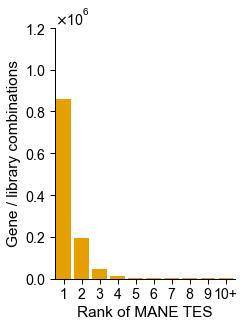

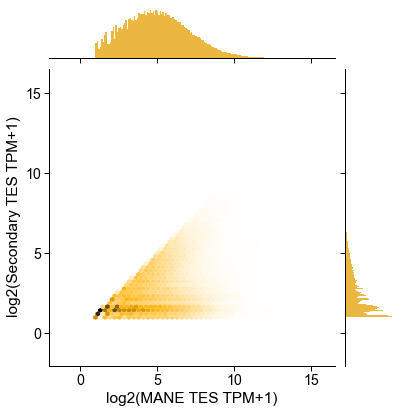

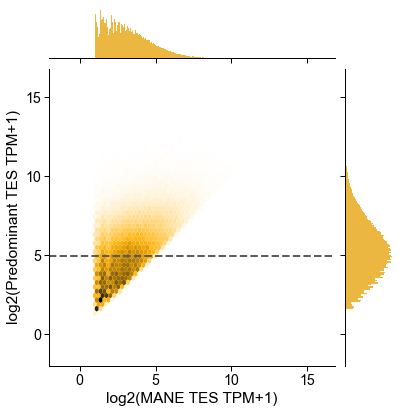

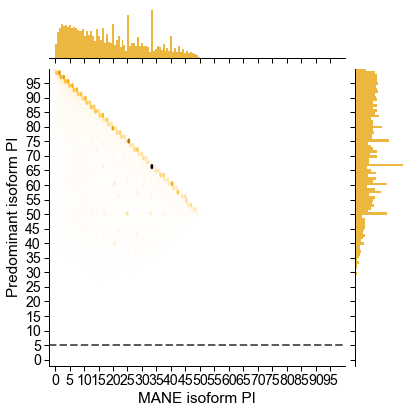

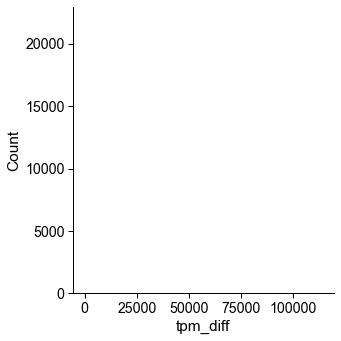

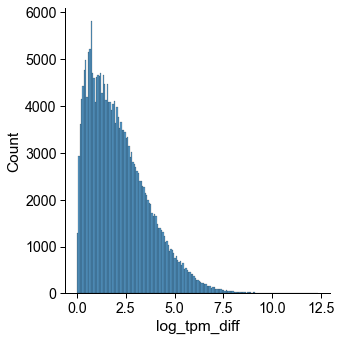

In [4]:
sg = swan.read(swan_file)
ca = cerberus.read(cerberus_h5)
mp_dfs = mane_analysis(sg, ca, 
                       ref_t_metadata,
                       ref_g_metadata,
                       'dataset',
                       min_tpm)

In [34]:
# get mane and non-mane intron chain IDs
df = mp_dfs['ic']

nm_df = df.loc[df.ic_princ_is_mane==False].copy(deep=True)[['ic_id_princ']].drop_duplicates()
nm_df.rename({'ic_id_princ': 'Name'}, axis=1, inplace=True)
nm_df = cerberus.split_cerberus_id(nm_df, 'ic')

In [68]:
mane_df = nm_df[['gene_id']].drop_duplicates()
mane_df['Name'] = mane_df['gene_id']+'_'+'1'

In [40]:
# get ic coords for each non mane predom ic and for mane ics
ca = cerberus.read(cerberus_h5)

In [38]:
ic_df = ca.ic.copy(deep=True)
ic_df.drop('gene_id', axis=1, inplace=True)
nm_df = nm_df.merge(ic_df, how='left', on='Name')
mane_df = mane_df.merge(ic_df, how='left', on='Name')

In [49]:
nm_df = nm_df[['Name', 'Coordinates', 'novelty', 'gene_id']]
mane_df = mane_df[['Name', 'Coordinates', 'gene_id']]
df = nm_df.merge(mane_df, on=['gene_id'], how='left', suffixes=('_predom', '_mane'))

In [69]:
# remove unspliced transcripts as definitionally they cannot
df['predom_subset_of_mane'] = df.apply(lambda x: x['Coordinates_predom'] in x['Coordinates_mane'] and x['Coordinates_predom'] != '-', axis=1)

In [70]:
temp = df[['Name_predom', 'predom_subset_of_mane']].groupby('predom_subset_of_mane').count().reset_index()
n = len(nm_df)
n_num = temp.loc[temp.predom_subset_of_mane==True, 'Name_predom'].values[0]
print(f'{(n_num/n)*100:.2f}% of non-mane predom ICs ({n_num}/{n}) are partial splice matches to MANE ICs')

29.02% of non-mane predom ICs (9931/34219) are partial splice matches to MANE ICs


In [71]:
temp = df[['Name_predom', 'novelty', 'predom_subset_of_mane']].groupby(['predom_subset_of_mane', 'novelty']).count().reset_index()
n_num_2 = temp.loc[(temp.novelty=='Known')&(temp.predom_subset_of_mane==True), 'Name_predom'].values[0]
print(f'{(n_num_2/n_num)*100:.2f}% of non-MANE subset predom ICs ({n_num_2}/{n_num}) are annotated')

59.68% of non-MANE subset predom ICs (5927/9931) are annotated


In [ ]:
## how often are non-mane predominant isoforms from mane clinical?

In [59]:
df = mp_dfs['triplet']

In [60]:
# get list of non-mane predom tids
df = df[['tid_princ']].drop_duplicates()
df = df.rename({'tid_princ': 'predom_tid'}, axis=1)
df['gid'] = df.predom_tid.str.split('[', n=1, expand=True)[0]

In [61]:
gtf_df, _, _ = get_gtf_info(how='iso', ver='v40_cerberus')

In [62]:
# get all mane tids, including select and plus clinical
mane_tids = gtf_df.loc[(gtf_df.MANE_Select==True)].tid.tolist()
print(len(mane_tids))
mane_tids = gtf_df.loc[(gtf_df.MANE_Select==True)|(gtf_df.MANE_Plus_Clinical==True)].tid.tolist()
print(len(mane_tids))
df['not_mane'] = ~df.predom_tid.isin(mane_tids)

18600
18656


In [63]:
temp = df[['gid', 'not_mane']].groupby('gid').any().reset_index().groupby('not_mane').count().reset_index()
n = temp['gid'].sum()
n_num = temp.loc[temp.not_mane==True, 'gid'].values[0]
print(f'{(n_num/n)*100:.2f}% of MANE genes ({n_num}/{n}) have >=1 library where predom iso != MANE')

86.08% of MANE genes (14383/16709) have >=1 library where predom iso != MANE


In [64]:
temp = df[['gid', 'not_mane']].groupby('gid').any().reset_index().groupby('not_mane').count().reset_index()
n = temp['gid'].sum()
n_num = temp.loc[temp.not_mane==True, 'gid'].values[0]
print(f'{(n_num/n)*100:.2f}% of MANE genes ({n_num}/{n}) have >=1 library where predom iso != MANE')

86.08% of MANE genes (14383/16709) have >=1 library where predom iso != MANE


## MANE analyses using samples

Read in graph from ../data/human/swan_graph.p
triplet
# genes: 16222
66.27% (10750/16222) of genes have a non-MANE predominant triplet in 80% of expressed samples
19.68% of genes (3192/16222) have predom == mane in all samples
30.21% of genes (4901/16222) have predom != mane in all samples
34.15% (119766/350704) ranked gene / library combinations where predominant isoform is not MANE
67.66% (156254/230938) of gene / sample combos where MANE is predominant triplet also have a secondary expressed triplet
38.22% (98590/257933) of gene / sample combos  where predominant triplet is not MANE have MANE expression
61.78% (159343/257933) of gene / sample combos  where predominant triplet is not MANE have NO MANE expression
80.32% (13030/16222) of genes have >= 1 sample where the predominant triplet is not MANE
69.79% (11321/16222) of genes have >= 1 sample where the predominant triplet is MANE

tss
ic
tes


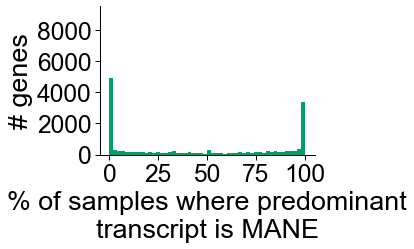

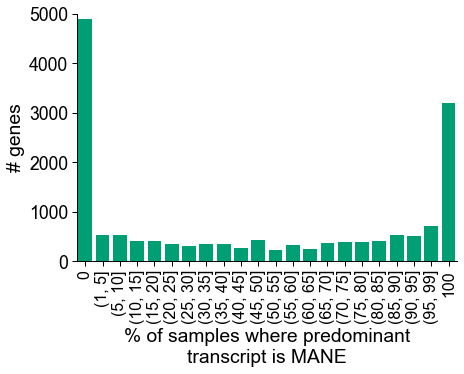

<Figure size 288x324 with 0 Axes>

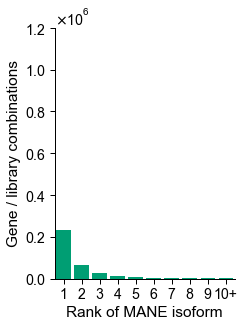

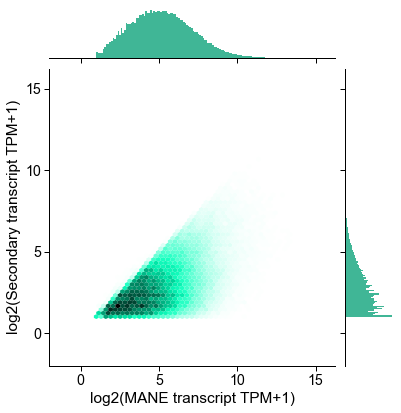

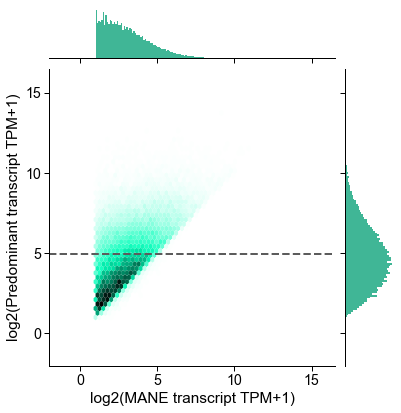

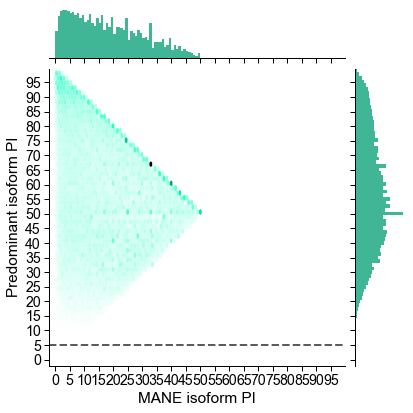

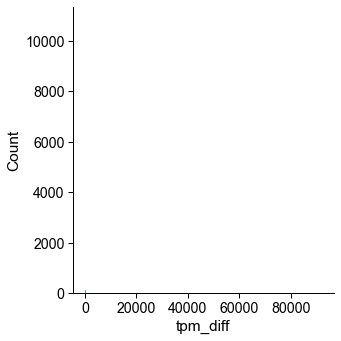

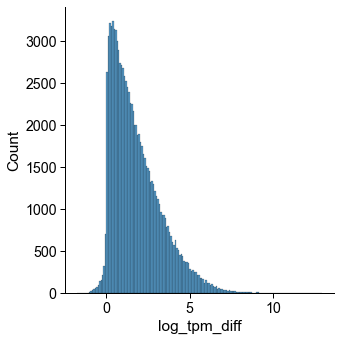

In [5]:
sg = swan.read(swan_file)
ca = cerberus.read(cerberus_h5)
mp_dfs = mane_analysis(sg, ca, 
                       ref_t_metadata,
                       ref_g_metadata,
                       'sample',
                       min_tpm,
                       feats=['triplet'])